In [27]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statistics import NormalDist
import glob
from collections import defaultdict

from scipy.stats import ttest_ind, f_oneway

from CrpStats import *

In [65]:
DATA_DIR = '/mnt/ernie_main/Ghassan/ephys/data/Epat26/LAC3-LAC4_5mA'
f = os.path.join(DATA_DIR, 'stim_resp_bipole.hdf5')
with h5py.File(f, 'r') as f:
    response = f['response_LA1 - LA2']
    crp = response['crp'][:]
    tr = response.attrs['Tr']
    fs = response.attrs['fs']
    crp_entry = np.zeros((1,fs))
    crp_entry[0,0:int(tr*fs)] = crp

In [68]:
np.dot(crp_entry[0, 0:int(tr*fs)], crp)

0.9999999999999993

In [58]:
fs

512

In [3]:

label_f = '~/Ephys/Data/all_pats_bipole_soz_labels.csv'
label_df = pd.read_csv(label_f, header=None)
label_df.columns = ['subj','bipole','label']
label_df.head(4)
dx_df = pd.read_csv("../../Data/Pat_Epilepsy_Subtype.csv")

In [4]:
TLE_IDS = dx_df[dx_df["Pure mTLE"] ==1].PatID.values
NON_TLE_IDS = dx_df[dx_df["Pure mTLE"] !=1].PatID.values

In [5]:

label_f = '~/Ephys/Data/all_pats_bipole_soz_labels.csv'
label_df = pd.read_csv(label_f, header=None)
label_df.columns = ['subj','bipole','label']



label_df = split_bipole(label_df)

label_df.label = label_df.label.apply(map_label)
label_df['bipole'] = label_df.bipole.apply(lambda x: x.replace(" ", ""))

relabel = defaultdict(lambda:"NIZ")
relabel['SOZ'] = 'SOZ' 
label_df['label'] = [relabel[x] for x in label_df.label.values]



In [6]:
label_df

,subj,bipole,label,contact
0,Epat31,AH3-AH4,SOZ,AH3
1,Epat31,AH4-AH5,SOZ,AH4
2,Epat31,AH5-AH6,SOZ,AH5
3,Epat31,PH1-PH2,SOZ,PH1
4,Epat31,PH2-PH3,SOZ,PH2
...,...,...,...,...
7048,Spat55,LCM6-LCM7,NIZ,LCM7
7049,Spat55,LCM8-LCM9,NIZ,LCM9
7050,Spat55,LCM9-LCM10,NIZ,LCM10
7051,Spat55,LCM10-LCM11,NIZ,LCM11


In [7]:
tst = '/mnt/ernie_main/Ghassan/ephys/data/Epat26/Epat26_stim.csv'
tst_df = pd.read_csv(tst)
tmp = merge_label(tst_df,label_df, 'resp_reg', 'bipole')


## Aggregating Results File
This stage reads through the results data on ernie and loads all stim csvs into one dataframe. 
This portion also labels the stim location as SOZ, NIZ, PZ, EZ, using label_df from above. For any regions unlabelled, the stim data is thrown out. 

In [8]:
RES_FILES = glob.glob('/mnt/ernie_main/Ghassan/ephys/data/*pat*/*pat*_stim.csv')
print(len(RES_FILES))
RES_FILES.remove( '/mnt/ernie_main/Ghassan/ephys/data/Spat56/Spat56_stim.csv')
#no label for file currently
print(len(RES_FILES))


26
25


In [9]:

res_df = agg_subject_results(RES_FILES, label_df.drop_duplicates())


24 subjects, total of 1517551 trials, dropped: 612058


### Loading Euclidean Distances

The all_pats_euclidean contains a truly massive csv of all bipole pairs and their calculated euclidean distance. This will become important in our analysis for 2 reasons:
1. In the ISH paper, we consider that contacts within 20mm of the stimulation electrode are overriden with stim artifact, thus we need to know to discount them.
2. We can use distance from stimulation source to understand the persistence of certain effects. For example, we expect that electrodes closer to the stimulation site will likely have higher explained variance (conduction effect + stim artifact that remains). So plotting explained variance over distance should help to disentangle some of these confounds

In [10]:
dist_df = pd.read_csv('/mnt/ernie_main/000_Data/SEEG/SEEG_EyesClosed_RestingState/labels/all_pats_euc_dist_list.csv',header=None)
dist_df.columns = ['subj', 'bipole1', 'bipole2','dist']
subj_set = set(res_df.subj)
dist_df = dist_df[dist_df.subj.isin(subj_set)]

In [11]:
dist_df

,subj,bipole1,bipole2,dist
220081,Epat26,LAC1-LAC2,LAC1-LAC2,0.0000
220082,Epat26,LAC1-LAC2,LP1-LP2,65.8629
220083,Epat26,LAC1-LAC2,LP2-LP3,65.3933
220084,Epat26,LAC1-LAC2,LTP1-LTP2,66.3953
220085,Epat26,LAC1-LAC2,LTP2-LTP3,66.1579
...,...,...,...,...
667058,Spat55,RAH12-RAH13,RAH8-RAH9,14.1735
667059,Spat55,RAH12-RAH13,RAH9-RAH10,10.5745
667060,Spat55,RAH12-RAH13,RAH10-RAH11,7.0017
667061,Spat55,RAH12-RAH13,RAH11-RAH12,3.5366


In [12]:
## Create a dictionary which takes in a subject and 2 contacts and maps those values 
## to a distance

dist_map = defaultdict(lambda: -1)
dist_map.update({f'{subj}-{bip1}-{bip2}':d for subj,bip1,bip2,d in dist_df[['subj','bipole1','bipole2','dist']].values})
dist_map.update({f'{subj}-{bip2}-{bip1}':d for subj,bip1,bip2,d in dist_df[['subj','bipole1','bipole2','dist']].values})

tst_df = res_df.copy(deep=True)
tst_df['dist'] = [dist_map[f"{subj}-{stim_reg}-{resp_reg}"] for subj,stim_reg,resp_reg in tst_df[['subj','stim_reg','resp_reg']].values]

In [13]:
resdist_df = tst_df

In [14]:
resdist_df

,alphas,TR,resp_reg,alpha_prime,explained_variance,t_peak_0,stim_reg,ma,subj,resp_reg_label,stim_reg_label,Unnamed: 0,dist
0,-85.664122,0.773438,LA3-LA4,-0.216324,0.126290,0.142813,LAC3-LAC4,5mA,Epat26,NIZ,NIZ,NaN,73.4286
1,3.287837,0.773438,LA3-LA4,0.008303,0.000291,0.142813,LAC3-LAC4,5mA,Epat26,NIZ,NIZ,NaN,73.4286
2,-18.637251,0.773438,LA3-LA4,-0.047064,0.008326,0.142813,LAC3-LAC4,5mA,Epat26,NIZ,NIZ,NaN,73.4286
3,98.596516,0.773438,LA3-LA4,0.248981,0.187390,0.142813,LAC3-LAC4,5mA,Epat26,NIZ,NIZ,NaN,73.4286
4,-82.030970,0.773438,LA3-LA4,-0.207149,0.137844,0.142813,LAC3-LAC4,5mA,Epat26,NIZ,NIZ,NaN,73.4286
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94095,-129.277484,0.078125,RPH5-RPH6,-3.231937,0.936492,0.076406,LAH11-LAH12,1mA,Spat55,NIZ,NIZ,NaN,96.2642
94096,36.182861,0.078125,RPH5-RPH6,0.904572,0.285267,0.076406,LAH11-LAH12,1mA,Spat55,NIZ,NIZ,NaN,96.2642
94097,13.503523,0.078125,RPH5-RPH6,0.337588,0.051016,0.076406,LAH11-LAH12,1mA,Spat55,NIZ,NIZ,NaN,96.2642
94098,-160.262739,0.078125,RPH5-RPH6,-4.006568,0.980377,0.076406,LAH11-LAH12,1mA,Spat55,NIZ,NIZ,NaN,96.2642


##### Filtering Down on the SPES Dataset
2 criteria here: 
1. Distance from the stim electrode - ISH used 20mm to ensure no stim artifact, I used 5 mm in my initial pass to be most permissive
2. Trial parameters : Only using 3mA trials. Most subcortical structures are not probed above 3mA for safety concerns. So this is the highest amperage we can assess most structures at. 

In [15]:
#Filtera conditions
resdist_df = resdist_df[resdist_df.dist > 20] #20mm is in line with ISH
resdist_df = resdist_df[resdist_df.ma == '3mA']
#resdist_df = resdist_df[resdist_df.TR > 20]

# Group Analysis
This is where the magic (should) be happening. Stim responses are grouped at level of stim region and response region then their group mean is calculated. Previously, each row in this dataframe represented the parameterization of each pulse. This first aggregation groups within trials 

In [16]:
cols = ['subj','stim_reg','resp_reg','alphas','alpha_prime','TR', 't_peak_0','dist', "resp_reg_label","stim_reg_label"]
group = resdist_df[cols].groupby(['subj','resp_reg', 'stim_reg',"resp_reg_label","stim_reg_label"])
group_df = group.mean()

In [17]:
group_df


alphas  \
subj   resp_reg  stim_reg    resp_reg_label stim_reg_label               
Epat26 LA1-LA2   LAC9-LAC10  NIZ            NIZ             -27.702660   
                 LAH1-LAH2   NIZ            SOZ              73.581857   
                 LAH7-LAH8   NIZ            NIZ              10.854676   
                 LAH9-LAH10  NIZ            NIZ            -122.257542   
                 LAM13-LAM14 NIZ            NIZ              98.254344   
...                                                                ...   
Spat55 RPH5-RPH6 LPH10-LPH11 NIZ            NIZ             -43.724903   
                 LPH8-LPH9   NIZ            NIZ             -39.994653   
                 LPP12-LPP13 NIZ            NIZ              86.526701   
                 RAH10-RAH11 NIZ            NIZ            -116.357326   
                 RPH13-RPH14 NIZ            NIZ              -6.250312   

                                                            alpha_prime  \
subj   resp_reg  stim_reg    resp_reg_label stim_reg_label                
Epat26 LA1-LA2   LAC9-LAC10  NIZ            NIZ               -2.770266   
                 LAH1-LAH2   NIZ            SOZ                0.518182   
                 LAH7-LAH8   NIZ            NIZ                0.201013   
                 LAH9-LAH10  NIZ            NIZ               -0.251559   
                 LAM13-LAM14 NIZ            NIZ                0.226392   
...                                                                 ...   
Spat55 RPH5-RPH6 LPH10-LPH11 NIZ            NIZ               -0.130913   
                 LPH8-LPH9   NIZ            NIZ               -2.221925   
                 LPP12-LPP13 NIZ            NIZ                0.313503   
                 RAH10-RAH11 NIZ            NIZ               -0.559410   
                 RPH13-RPH14 NIZ            NIZ               -0.625031   

                                                                  TR  \
subj   resp_reg  stim_reg    resp_reg_label stim_reg_label             
Epat26 LA1-LA2   LAC9-LAC10  NIZ            NIZ             0.019531   
                 LAH1-LAH2   NIZ            SOZ             0.277344   
                 LAH7-LAH8   NIZ            NIZ             0.105469   
                 LAH9-LAH10  NIZ            NIZ             0.949219   
                 LAM13-LAM14 NIZ            NIZ             0.847656   
...                                                              ...   
Spat55 RPH5-RPH6 LPH10-LPH11 NIZ            NIZ             0.652344   
                 LPH8-LPH9   NIZ            NIZ             0.035156   
                 LPP12-LPP13 NIZ            NIZ             0.539062   
                 RAH10-RAH11 NIZ            NIZ             0.406250   
                 RPH13-RPH14 NIZ            NIZ             0.019531   

                                                            t_peak_0     dist  
subj   resp_reg  stim_reg    resp_reg_label stim_reg_label                     
Epat26 LA1-LA2   LAC9-LAC10  NIZ            NIZ             0.010000  79.6650  
                 LAH1-LAH2   NIZ            SOZ             0.068594  47.4889  
                 LAH7-LAH8   NIZ            NIZ             0.092031  40.6558  
                 LAH9-LAH10  NIZ            NIZ             0.902578  40.3105  
                 LAM13-LAM14 NIZ            NIZ             0.840078  52.8940  
...                                                              ...      ...  
Spat55 RPH5-RPH6 LPH10-LPH11 NIZ            NIZ             0.426016  88.8157  
                 LPH8-LPH9   NIZ            NIZ             0.015859  82.1453  
                 LPP12-LPP13 NIZ            NIZ             0.228750  80.8635  
                 RAH10-RAH11 NIZ            NIZ             0.131094  24.2677  
                 RPH13-RPH14 NIZ            NIZ             0.015859  28.4858  

[43476 rows x 5 columns]

In [18]:
resdist_df['stim_rel'] = [f"{a}-{b}" for a,b in resdist_df[['resp_reg_label','stim_reg_label']].values]
resdist_df['stim_sesh'] = [f"{stim}-{resp}" for stim, resp in resdist_df[['stim_reg','resp_reg']].values ]
stim_rel_map = {f"{subj}-{stim_sesh}":stim_rel for subj,stim_sesh,stim_rel in resdist_df[['subj','stim_sesh','stim_rel']].values}

In [19]:

tmp =resdist_df[['subj','explained_variance', 'dist', 'stim_sesh']].groupby(["subj","stim_sesh"]).mean().reset_index()
tmp['stim_rel'] = [stim_rel_map[f'{subj}-{stim_sesh}'] for subj,stim_sesh in tmp[['subj', 'stim_sesh']].values]
ev_dist_df = tmp

tmp.shape

In [20]:
tmp = resdist_df[['subj','alpha_prime','TR','explained_variance', 't_peak_0', 'stim_rel','dist','stim_sesh']]
tmp = tmp.groupby(['subj','stim_sesh','stim_rel']).mean()
resdist_trial_df = tmp.reset_index()

In [26]:
out_dir = "/mnt/ernie_main/Ghassan/ephys/data/"
resdist_trial_df.to_csv(os.path.join(out_dir, "crp_trials.csv"))

In [22]:
# get NIZ stats
def ref_stats(trial_df, cols, stim_rel='NIZ-NIZ'):
    """Returns dictionary containing statistics for reference condition on features of interest. 
    For example, if you are interested in average deflection of SOZ-SOZ compared to NIZ-NIZ, pass in
    'alpha_prime' as an element of the COLS argument and routine will use stim_rel='NIZ-NIZ' 

    Args:
        trial_df (_type_): _description_
        cols (_type_): _description_
        stim_rel (str, optional): _description_. Defaults to 'NIZ-NIZ'.

    Returns:
        _type_: _description_
    """
    subj_stats = dict()
    for feat in cols:
        subj_stats[feat] = dict()
    
    for subj in set(trial_df.subj):
        subj_df = trial_df[trial_df.subj==subj]
        subj_ref_df = subj_df[subj_df.stim_rel == stim_rel]

        for feat in cols:
            mu = subj_ref_df[feat].mean()
            stdev = subj_ref_df[feat].std()
            feat_stats = subj_stats[feat]
            feat_stats[subj] = (mu, stdev)
    return subj_stats

sub_stats = ref_stats(resdist_trial_df, ['alpha_prime', "TR", "explained_variance","t_peak_0"])
sub_stats.keys()

dict_keys(['alpha_prime', 'TR', 'explained_variance', 't_peak_0'])

In [23]:
# z score
dfs = []
for subj in set(resdist_trial_df.subj):
    tmp = resdist_trial_df[resdist_trial_df.subj == subj]
    sub_niz_alpha = sub_stats['alpha_prime']
    dist = NormalDist(*sub_niz_alpha[subj])
    tmp['alpha_z'] = (tmp.alpha_prime - sub_niz_alpha[subj][0])/(sub_niz_alpha[subj][1])
    sub_niz_tr = sub_stats['TR']
    tr_dist = NormalDist(*sub_niz_tr[subj])
    tmp['TR_z'] = tmp.TR.apply(tr_dist.zscore)

    sub_niz_ev = sub_stats['explained_variance']
    ev_dist = NormalDist(*sub_niz_ev[subj])
    tmp['ev_z'] = tmp.explained_variance.apply(ev_dist.zscore)

    sub_peak_t = sub_stats['t_peak_0']
    peak_t_dist = NormalDist(*sub_peak_t[subj])
    tmp['peak_t_z'] = tmp.t_peak_0.apply(peak_t_dist.zscore)
    dfs.append(tmp)

z_dfs = pd.concat(dfs)
    

/tmp/ipykernel_123206/1497161718.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['alpha_z'] = (tmp.alpha_prime - sub_niz_alpha[subj][0])/(sub_niz_alpha[subj][1])
/tmp/ipykernel_123206/1497161718.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['TR_z'] = tmp.TR.apply(tr_dist.zscore)
/tmp/ipykernel_123206/1497161718.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [24]:
tmp = z_dfs[['subj','alpha_z','TR_z', 'peak_t_z','explained_variance', 'stim_rel','dist']]
zgroup = tmp.groupby(['subj','stim_rel']).mean()
zgroup_df = zgroup.reset_index()
zgroup_df

,subj,stim_rel,alpha_z,TR_z,peak_t_z,explained_variance,dist
0,Epat26,NIZ-NIZ,5.956931e-19,-3.559266e-17,-2.308311e-17,0.410924,53.019712
1,Epat26,NIZ-SOZ,-1.587556e-02,3.385090e-01,2.496369e-01,0.402615,51.203601
2,Epat26,SOZ-NIZ,1.245606e-01,2.190930e-01,1.534245e-01,0.392402,54.356116
3,Epat26,SOZ-SOZ,4.322037e-01,1.204932e-01,-1.968868e-01,0.485171,39.320392
4,Epat27,NIZ-NIZ,-4.254504e-18,-6.543833e-17,2.907245e-17,0.422067,57.501175
...,...,...,...,...,...,...,...
80,Spat53,NIZ-NIZ,5.046468e-18,-1.077227e-16,-5.056173e-17,0.446315,42.687993
81,Spat53,NIZ-SOZ,4.136023e-02,-1.984623e-02,-6.828936e-02,0.500731,49.196632
82,Spat53,SOZ-NIZ,1.697931e-01,-7.142470e-02,-1.478532e-01,0.424006,48.869645
83,Spat55,NIZ-NIZ,-5.393551e-18,-9.926557e-17,1.654426e-16,0.458164,51.002985


In [25]:
#investigating restult aggregation
# # expecting each subject to have some data from the SOZ-SOZ stim range
# full_set = set(zgroup_df.subj)
# full_set.difference(zgroup_df[zgroup_df.stim_rel =='SOZ-SOZ'].subj)

## Distance Between Sites

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

F values for distances between stim contact and response contact:226.365890650322
 p-values:9.793752481524208e-146


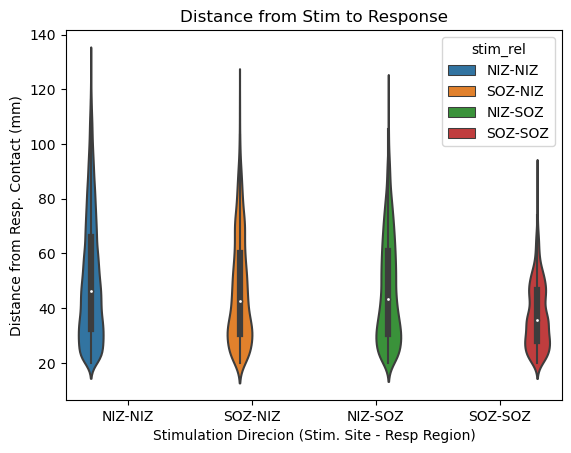

In [37]:
cols = ['NIZ-NIZ', 'SOZ-SOZ','SOZ-NIZ', 'NIZ-SOZ']

sns.violinplot(ev_dist_df[ev_dist_df.stim_rel.isin(cols)],y='dist', x='stim_rel',hue='stim_rel')
plt.ylabel("Distance from Resp. Contact (mm)")
plt.xlabel("Stimulation Direcion (Stim. Site - Resp Region)")
plt.title("Distance from Stim to Response")
plt.savefig("../viz/stim_dists.pdf", transparent=True)
#TODO ttest distances to make sure they're not super diff
a = ev_dist_df[ev_dist_df.stim_rel =='NIZ-NIZ'].dist
b = ev_dist_df[ev_dist_df.stim_rel == 'NIZ-SOZ'].dist
c = ev_dist_df[ev_dist_df.stim_rel == 'SOZ-NIZ'].dist
d = ev_dist_df[ev_dist_df.stim_rel == 'SOZ-SOZ'].dist
F, p  = f_oneway(a, b, c, d)
print(f"F values for distances between stim contact and response contact:{F}\n p-values:{p}")

#### Compariing distance between stim region and response region. 
It seems like the average distance is quite different between the various stim relations

In [38]:

mTLE_df = ev_dist_df[ev_dist_df.subj.isin(TLE_IDS)]
print(f"shape of TLE df {mTLE_df.shape}")
nonfocal_df = ev_dist_df[ev_dist_df.subj.isin(NON_TLE_IDS)]
print(f"shape of non TLE df {nonfocal_df.shape}")

shape of TLE df (17107, 5)
shape of non TLE df (24459, 5)


/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

TtestResult(statistic=34.4890798634, pvalue=5.0243904885841926e-257, df=41564.0)


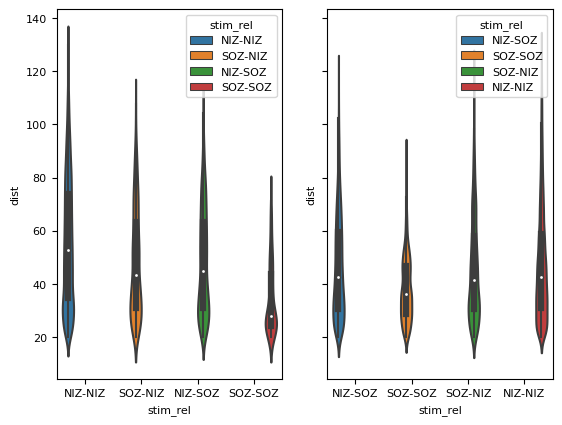

In [39]:
plt.rcParams.update({'font.size': 8})

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2,sharey=True)
ax = sns.violinplot(mTLE_df, x='stim_rel', y='dist',hue='stim_rel',ax=ax1,legend=False)
ax = sns.violinplot(nonfocal_df, x='stim_rel', y='dist',hue='stim_rel',ax=ax2, legend=False)
tle_alpha = mTLE_df.dist
non_alpha = nonfocal_df.dist

print(ttest_ind(tle_alpha, non_alpha))

In [40]:
def bin_distances(dist, binsize=2):
    return dist//binsize
ev_dist_df['dist_bin'] = ev_dist_df.dist.apply(bin_distances)*2


/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

At 128.0 dist ANOVA returns F_onewayResult(statistic=nan, pvalue=nan)
At 20.0 dist ANOVA returns F_onewayResult(statistic=8.662304374255694, pvalue=1.0394554487101722e-05)
At 22.0 dist ANOVA returns F_onewayResult(statistic=9.08428488371683, pvalue=5.830823044543537e-06)
At 24.0 dist ANOVA returns F_onewayResult(statistic=10.38284989577467, pvalue=8.884571333914719e-07)
At 26.0 dist ANOVA returns F_onewayResult(statistic=3.007880443303982, pvalue=0.02923733644963955)
At 28.0 dist ANOVA returns F_onewayResult(statistic=6.798432556438576, pvalue=0.00014747307397283672)
At 30.0 dist ANOVA returns F_onewayResult(statistic=2.07721455795214, pvalue=0.10122901667215585)
At 32.0 dist ANOVA returns F_onewayResult(statistic=0.5184747023371881, pvalue=0.6695953991155381)
At 34.0 dist ANOVA returns F_onewayResult(statistic=1.297241707516506, pvalue=0.2737305482302962)
At 36.0 dist ANOVA returns F_onewayResult(statistic=1.440562842404488, pvalue=0.2291919959674452)
At 38.0 dist ANOVA returns F_onew

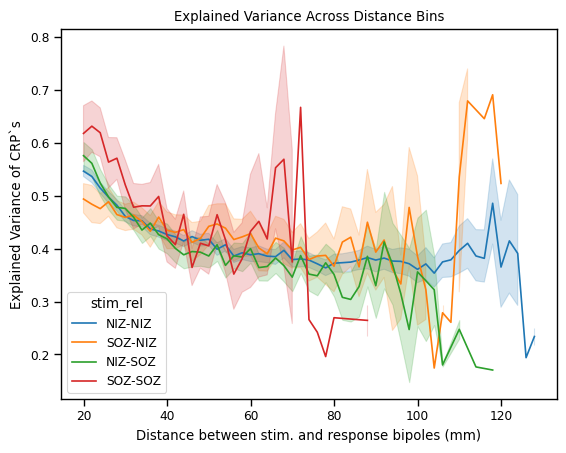

In [41]:
with sns.plotting_context("paper"):
    ax = sns.lineplot(ev_dist_df, x="dist_bin", y='explained_variance', hue='stim_rel')
    plt.xlabel("Distance between stim. and response bipoles (mm)")
    plt.ylabel("Explained Variance of CRP`s")
for bin in set(ev_dist_df.dist_bin):
    df = ev_dist_df[ev_dist_df.dist_bin == bin]
    a = df[df.stim_rel == "SOZ-SOZ"].explained_variance
    b = df[df.stim_rel == "SOZ-NIZ"].explained_variance
    c = df[df.stim_rel == "NIZ-SOZ"].explained_variance
    d = df[df.stim_rel == "NIZ-NIZ"].explained_variance
    print(f"At {bin} dist ANOVA returns {f_oneway(a, b, c,d)}")
    plt.title("Explained Variance Across Distance Bins")
#TODO - anova each bin

plot_df = ev_dist_df[['subj','stim_rel','dist','explained_variance']].groupby(['subj','stim_rel']).mean().reset_index()
# plot_df = ev_dist_df
cols = ['NIZ-NIZ', 'NIZ-SOZ', 'SOZ-SOZ', 'SOZ-NIZ']
sns.scatterplot(data=plot_df[plot_df.stim_rel.isin(cols)], x='dist', y='explained_variance', hue='stim_rel')
plt.title("Explained Variance vs Distance")
plt.xlabel("Distance from Resp Contact (euclidean)")
plt.ylabel("Explained Variance of top CRP")
plt.savefig(f"../viz/ev_by_stim_rel.pdf",transparent=True)

In [ ]:
# sns.lineplot(data=zgroup_df, x='dist', y='explained_variance', hue='stim_rel')


sns.scatterplot(data=zgroup_df, x='dist', y='explained_variance', hue='subj')
plt.title("Explained Variance vs Distance ")
plt.xlabel("Distance from stim to response (euclidean)")
plt.ylabel("Explained Variance of top CRP")
plt.savefig(f"../viz/ev_dist_from_stim.pdf",transparent=True)

In [ ]:

from scipy.stats import ttest_1samp

In [ ]:
plt.rcParams.update({'font.size': 16})


### Alpha Prime 
Testing Average Deflection - should represent strength of canonical response    

In [ ]:
tst_df = z_dfs

In [ ]:
# sns.histplot(data=tst_df,hue='stim_rel', x='alpha_z')

AttributeError: 'DataFrame' object has no attribute 'stim_rel'

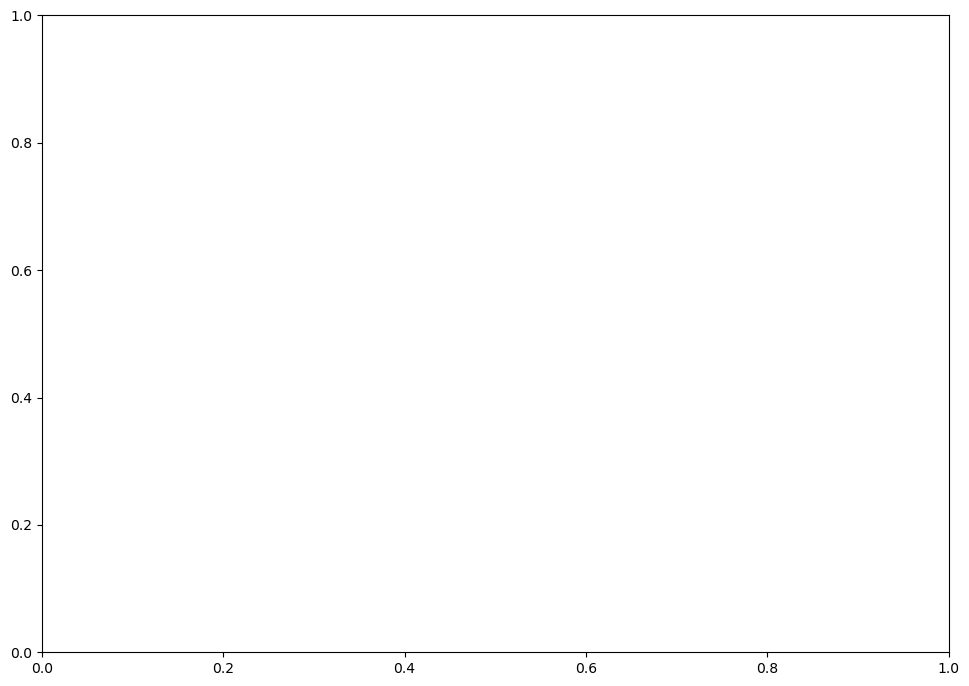

In [25]:
fig, ax = plt.subplots(figsize=[11.7,8.27])
cols = [ 'NIZ-NIZ', 'NIZ-SOZ', 'SOZ-SOZ', 'SOZ-NIZ']

ax = sns.boxplot(tst_df[tst_df.stim_rel.isin(cols)], x='stim_rel', y='alpha_z',hue='stim_rel',ax=ax)
a = tst_df[tst_df.stim_rel=='NIZ-SOZ'].alpha_z
b = tst_df[tst_df.stim_rel =='SOZ-SOZ'].alpha_z
c = tst_df[tst_df.stim_rel == 'SOZ-NIZ'].alpha_z
d =  tst_df[tst_df.stim_rel == 'NIZ-NIZ'].alpha_z

# print(f"SOZ-SOZ mean : {np.mean(b)} vs NIZ->SOZ mean {np.mean(a)}")

# print(f"SOZ->NIZ: {np.mean(c)} vs NIZ->SOZ mean {np.mean(a)}")
# print(f"Comparing NIZ-NIZ  vs NIZ-SOZ: {ttest_ind(d,a)}")
# print(f"Comparing SOZ-SOZ to NIZ-SOZ: {ttest_ind(b,a)}")
# print(f"Comparing SOZ-SOZ to NIZ-SOZ: {ttest_ind(b,c)}")
# print(f"Comparing stimulation in SOZ to NIZ with into the SOZ from the NIZ: {ttest_ind(a,c)}")
print(f"Result of omnnibus test, ANOCA: {f_oneway(a,b,c,d)}")

plt.ylabel("Canonical Response Deflection (z)")
plt.xlabel("Direction of Relationship: Origin-Response")
plt.title("CRP Deflection within/into SOZ")
plt.ylim(-2,2 )
plt.savefig("../viz/relabel_boxplot_crp_alphaz_box.pdf", transparent=True)

#### Alpha Sub-Analysis mTLE group vs non
Do patients with mTLE have higher deflections within the SOZ?

In [26]:
mTLE_df = tst_df[tst_df.subj.isin(TLE_IDS)]
print(f"shape of TLE df {mTLE_df.shape}")
nonfocal_df = tst_df[tst_df.subj.isin(NON_TLE_IDS)]
print(f"shape of non TLE df {nonfocal_df.shape}")

shape of TLE df (603925, 13)
shape of non TLE df (851257, 13)


In [27]:
mTLE_df

,alphas,TR,resp_reg,alpha_prime,explained_variance,t_peak_0,stim_reg,ma,subj,resp_reg_label,stim_reg_label,Unnamed: 0,dist
0,-85.664122,0.773438,LA3-LA4,-0.216324,0.126290,0.023438,LAC3-LAC4,5mA,Epat26,NIZ,NIZ,NaN,73.4286
1,3.287837,0.773438,LA3-LA4,0.008303,0.000291,0.023438,LAC3-LAC4,5mA,Epat26,NIZ,NIZ,NaN,73.4286
2,-18.637251,0.773438,LA3-LA4,-0.047064,0.008326,0.023438,LAC3-LAC4,5mA,Epat26,NIZ,NIZ,NaN,73.4286
3,98.596516,0.773438,LA3-LA4,0.248981,0.187390,0.023438,LAC3-LAC4,5mA,Epat26,NIZ,NIZ,NaN,73.4286
4,-82.030970,0.773438,LA3-LA4,-0.207149,0.137844,0.023438,LAC3-LAC4,5mA,Epat26,NIZ,NIZ,NaN,73.4286
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60456,517.258770,0.183594,SF6-SF7,5.502753,0.970384,0.011719,IT1-IT2,2mA,Spat41,NIZ,SOZ,NaN,73.4622
60457,22.411612,0.183594,SF6-SF7,0.238421,0.013315,0.011719,IT1-IT2,2mA,Spat41,NIZ,SOZ,NaN,73.4622
60458,39.915220,0.183594,SF6-SF7,0.424630,0.032095,0.011719,IT1-IT2,2mA,Spat41,NIZ,SOZ,NaN,73.4622
60459,-21.461631,0.183594,SF6-SF7,-0.228315,0.003928,0.011719,IT1-IT2,2mA,Spat41,NIZ,SOZ,NaN,73.4622


ValueError: Could not interpret input 'stim_rel'

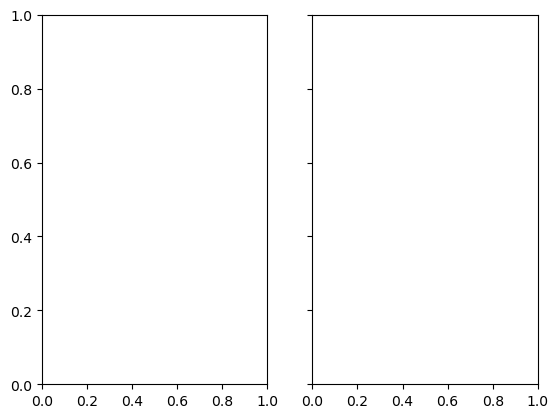

In [28]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2,sharey=True)
ax = sns.boxplot(mTLE_df, x='stim_rel', y='alpha_z',hue='stim_rel',ax=ax1)
ax = sns.boxplot(nonfocal_df, x='stim_rel', y='alpha_z',hue='stim_rel',ax=ax2)
tle_alpha = mTLE_df[mTLE_df.stim_rel =='SOZ-SOZ'].alpha_z
non_alpha = nonfocal_df[nonfocal_df.stim_rel =='SOZ-SOZ'].alpha_z

print(ttest_ind(tle_alpha, non_alpha))

## Response Peak Timing

In [29]:
tst_df = zgroup_df

NameError: name 'zgroup_df' is not defined

AttributeError: 'DataFrame' object has no attribute 'stim_rel'

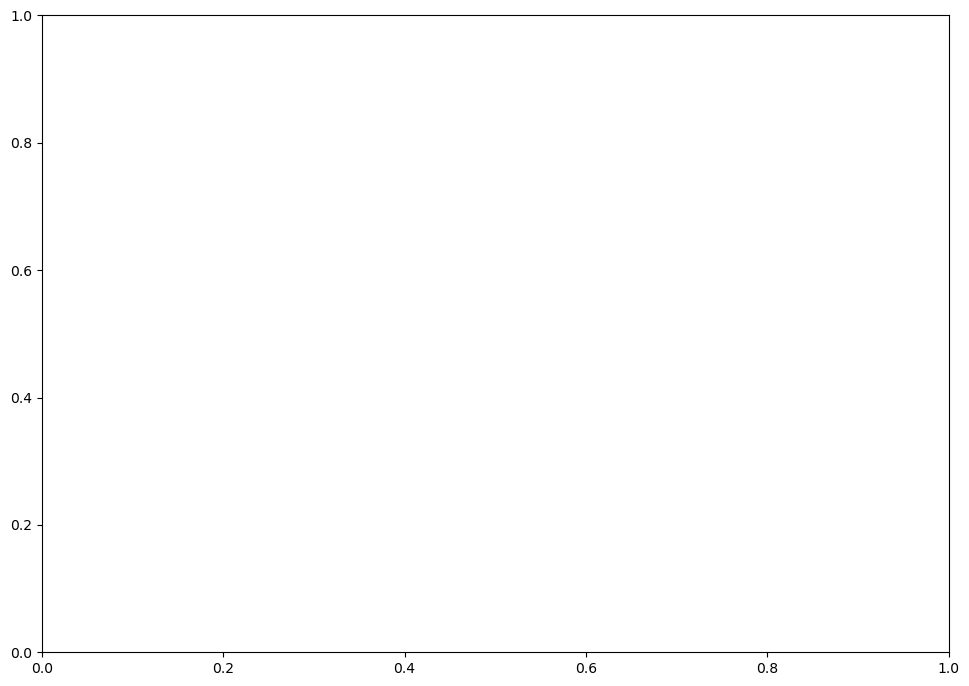

In [30]:

fig, ax = plt.subplots(figsize=[11.7,8.27])
cols = [ 'NIZ-NIZ', 'NIZ-SOZ', 'SOZ-SOZ', 'SOZ-NIZ']

ax = sns.boxplot(tst_df[tst_df.stim_rel.isin(cols)], x='stim_rel', y='peak_t_z',hue='stim_rel',ax=ax)
a = tst_df[tst_df.stim_rel=='NIZ-SOZ'].peak_t_z
b = tst_df[tst_df.stim_rel =='SOZ-SOZ'].peak_t_z
c = tst_df[tst_df.stim_rel == 'SOZ-NIZ'].peak_t_z
d =  tst_df[tst_df.stim_rel == 'NIZ-NIZ'].peak_t_z

# print(f"SOZ-SOZ mean : {np.mean(b)} vs NIZ->SOZ mean {np.mean(a)}")

# print(f"SOZ->NIZ: {np.mean(c)} vs NIZ->SOZ mean {np.mean(a)}")
print(f"Comparing NIZ-NIZ  vs NIZ-SOZ: {ttest_ind(d,a)}")
print(f"Comparing SOZ-SOZ to NIZ-SOZ: {ttest_ind(b,a)}")
print(f"Comparing SOZ-SOZ to NIZ-SOZ: {ttest_ind(b,c)}")
print(f"Comparing stimulation in SOZ to NIZ with into the SOZ from the NIZ: {ttest_ind(a,c)}")
print(f"Result of omnnibus test, ANOVA: {f_oneway(a,b,c,d)}")

plt.ylabel("Reponse timing compared to NIZ-NIZ (z)")
plt.xlabel("Direction of Relationship: Origin-Response")
plt.title("CRP Peak Response Timing")
plt.ylim(-2,2 )
plt.savefig("../viz/relabel_boxplot_crp_peak_timing_box.pdf", transparent=True)

### Tr_z Response Duration
Note: this is not the same as examining delay -> this would require a bit more investigation into onset times

NameError: name 'z_dfs' is not defined

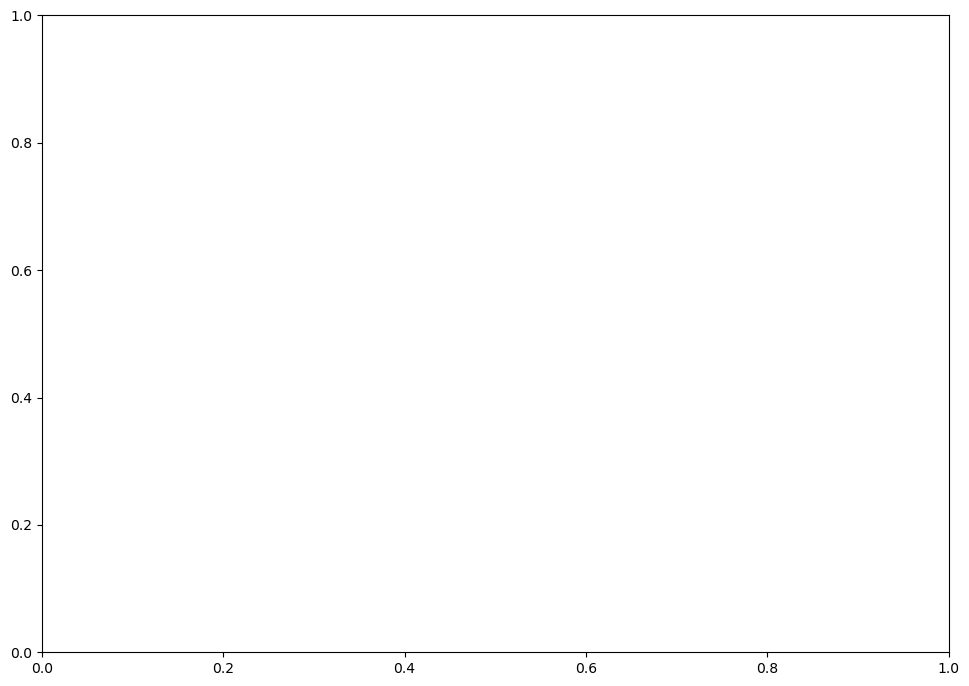

In [31]:
fig, ax = plt.subplots(figsize=[11.7,8.27])
tst_df = z_dfs

ax = sns.boxplot(tst_df, x='stim_rel', y='TR_z',hue='stim_rel',ax=ax)
a = tst_df[tst_df.stim_rel=='NIZ-SOZ'].TR_z
b = tst_df[tst_df.stim_rel =='SOZ-SOZ'].TR_z
c = tst_df[tst_df.stim_rel == 'PZ-SOZ'].TR_z
d =  tst_df[tst_df.stim_rel == 'PZ-PZ'].TR_z

# b= ttest_1samp(b,0)
# print(b)
print(f"NIZ-SOZ zscore {np.mean(a)}")
print(f"SOZ-SOZ zscore {np.mean(b)}")
print(ttest_ind(a,b))
# print(ttest_1samp(c,0))
# print(ttest_1samp(d,0) )


plt.ylabel("Canonical Response Duration (z)")
plt.title("CRP TR")
plt.savefig("../viz/relabel_crp_TRz.pdf",transparent=True)

### Explained Variance

NameError: name 'zgroup_df' is not defined

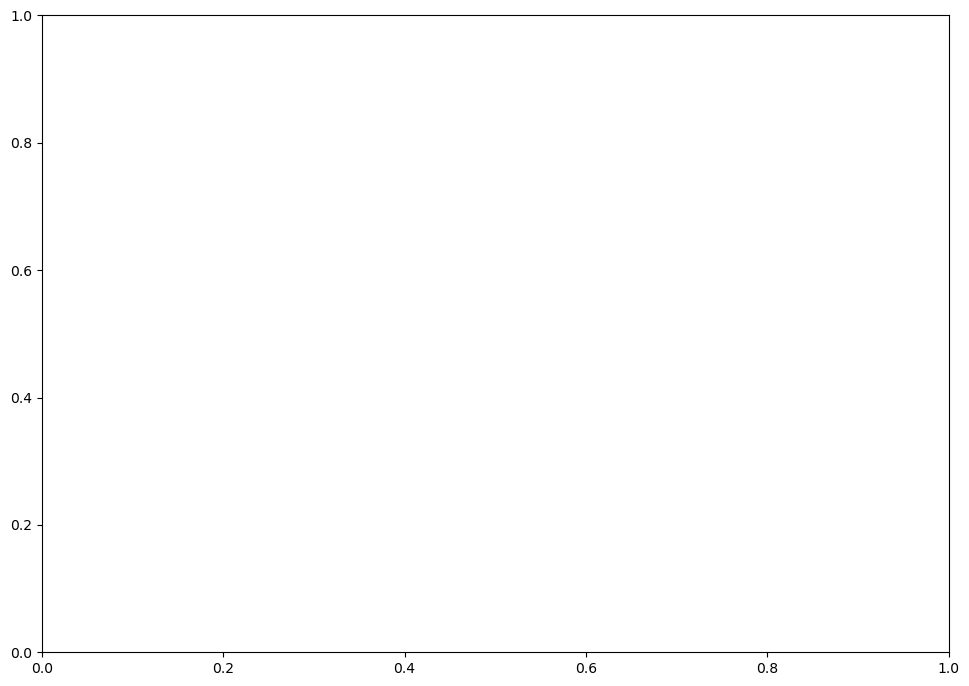

In [33]:

fig, ax = plt.subplots(figsize=[11.7,8.27])

ev_df = zgroup_df
ax = sns.violinplot(ev_df, x='stim_rel', y='explained_variance',hue='stim_rel', width=.8, ax=ax)
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.2,1.2))
a = ev_df[ev_df.stim_rel=='NIZ-SOZ'].explained_variance
b = ev_df[ev_df.stim_rel =='SOZ-SOZ'].explained_variance
c = ev_df[ev_df.stim_rel == 'NIZ-NIZ'].explained_variance
d =  ev_df[ev_df.stim_rel == 'SOZ-NIZ'].explained_variance
print(f"Result of omnbius, ANOVA: {f_oneway(a,b,c,d)}")

p_map = np.zeros((4,4))
for i,ev1 in enumerate([a,b,c,d]):
    for j,ev2 in enumerate([a,b,c,d]):
        p_map[i,j] = ttest_ind(ev1,ev2).pvalue
# print(ttest_1samp(c,0))
# print(ttest_1samp(d,0) )

#TODO OMNIBUS test
plt.ylabel("Canonical Response Explained Variance")
plt.title("CRP Explained Variance")
plt.xlabel("Direction of Relationship: Origin-Response")
plt.savefig("../viz/relabel_CRP_ev_box.pdf", transparent=True, bbox_inches='tight')

In [74]:
bonf_corr

0.004166666666666667

<Axes: >

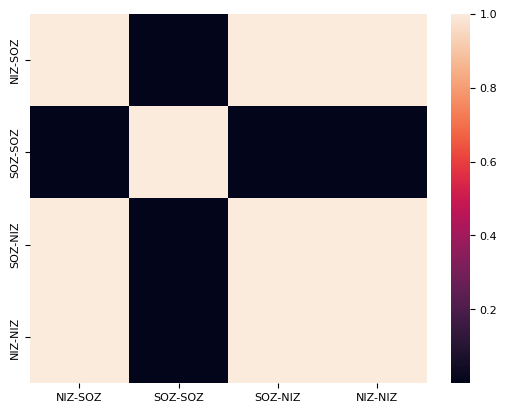

In [75]:
ticklabels= ['NIZ-SOZ', 'SOZ-SOZ', 'SOZ-NIZ', 'NIZ-NIZ']
bonf_corr = .05 / (len(p_map.flatten()) - p_map.shape[0])
p_map[p_map >= bonf_corr] = 1
sns.heatmap(p_map,xticklabels=ticklabels, yticklabels=ticklabels)

In [1]:
1e-4

0.0001

In [2]:
.05/12

0.004166666666666667

In [76]:
p_map

array([[1.00000000e+00, 3.76807836e-04, 1.00000000e+00, 1.00000000e+00],
       [3.76807836e-04, 1.00000000e+00, 1.79265429e-04, 5.42514852e-04],
       [1.00000000e+00, 1.79265429e-04, 1.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 5.42514852e-04, 1.00000000e+00, 1.00000000e+00]])

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

0.5454936508275412
TtestResult(statistic=-3.7318213272406684, pvalue=0.0006541276782689715, df=36.0)


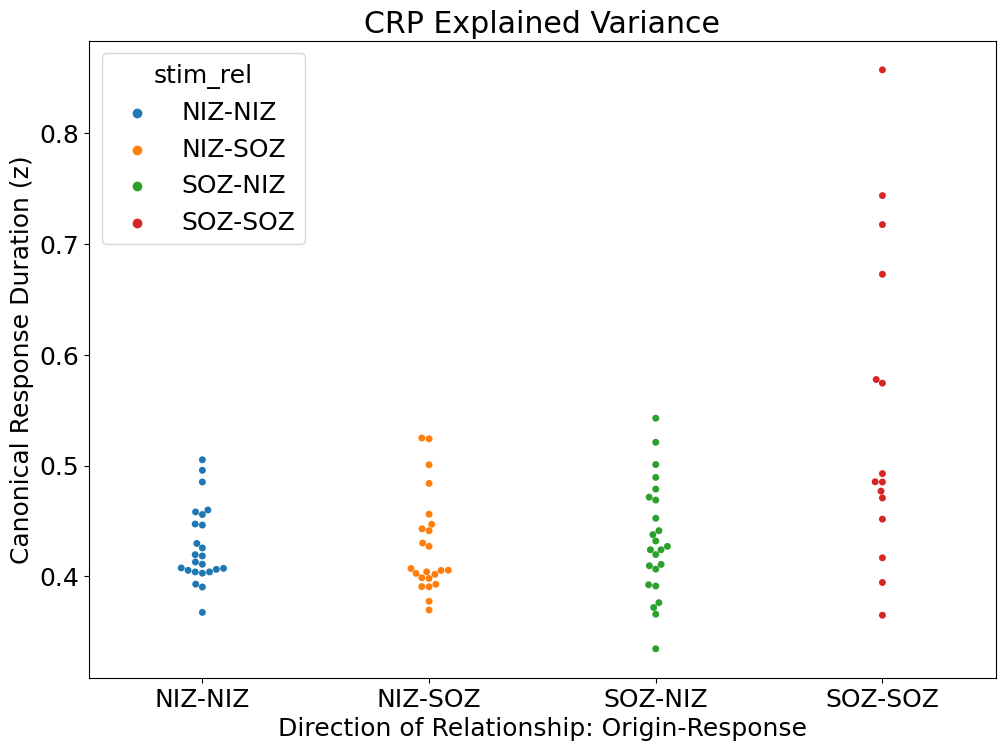

In [61]:
# fig, ax = plt.subplots(figsize=[11.7,8.27])


# ax = sns.swarmplot(tst_df[tst_df.stim_rel.isin(cols)], x='stim_rel', y='explained_variance',hue='stim_rel',ax=ax)
# a = tst_df[tst_df.stim_rel=='NIZ-SOZ'].explained_variance
# b = tst_df[tst_df.stim_rel =='SOZ-SOZ'].explained_variance
# c = tst_df[tst_df.stim_rel == 'PZ-SOZ'].explained_variance
# d =  tst_df[tst_df.stim_rel == 'PZ-PZ'].explained_variance

# # b= ttest_1samp(b,0)
# print(np.mean(b))
# print(ttest_ind(a,b))
# # print(ttest_1samp(c,0))
# # print(ttest_1samp(d,0) )
# #TODO sample 4


# plt.ylabel("Canonical Response Duration (z)")
# plt.title("CRP Explained Variance")
# plt.xlabel("Direction of Relationship: Origin-Response")

# plt.savefig("../viz/relabel_CRP_ev_swarm.pdf", transparent=True)

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

TtestResult(statistic=2.8844287382140266, pvalue=0.012784302202213105, df=13.0)


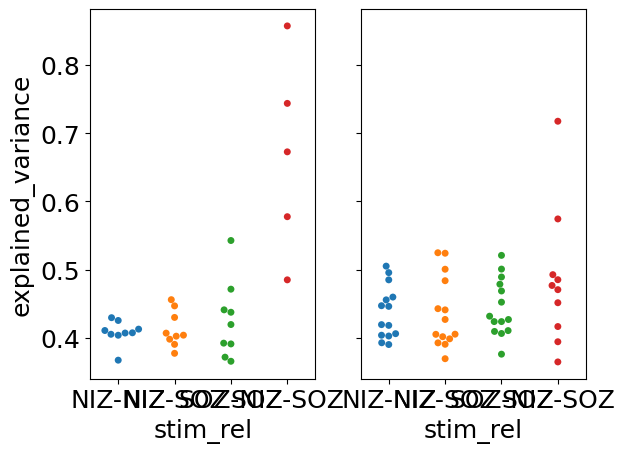

In [65]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2,sharey=True)

plt.rcParams.update({'font.size': 8})
ax = sns.boxplot(mTLE_df, x='stim_rel', y='explained_variance',hue='stim_rel',ax=ax1, legend=False)
ax = sns.boxplot(nonfocal_df, x='stim_rel', y='explained_variance',hue='stim_rel',ax=ax2, legend=False)
tle_alpha = mTLE_df[mTLE_df.stim_rel =='SOZ-SOZ'].explained_variance
non_alpha = nonfocal_df[nonfocal_df.stim_rel =='SOZ-SOZ'].explained_variance

print(ttest_ind(tle_alpha, non_alpha))

----

In [ ]:
# sns.histplot(data=group_df, x= 'alpha_prime', hue='stim_reg_label',multiple='stack',log_scale=True)
# plt.title("Alpha prime Across all locations")

In [ ]:
# tst = group_df.reset_index()
# tst = tst[tst.resp_reg_label =='SOZ']
# sns.histplot(data=tst, x= 'alpha_prime', hue='stim_reg_label',multiple='stack',log_scale=True)
# plt.title("Alpha prime in SOZ locations")

In [ ]:
# tst = group_df.reset_index()
# tst = tst[tst.resp_reg_label =='PZ']
# sns.histplot(data=tst, x= 'alpha_prime', hue='stim_reg_label',multiple='stack',log_scale=True)
# plt.title("Alpha prime in PZ locations")


In [ ]:
# sns.violinplot(plot_df[plot_df.subj==plot_df.subj.values[0]],x='resp_reg_label', y='alpha_prime', hue='stim_reg_label', log_scale=True)
